<a href="https://colab.research.google.com/github/youngsoopar/Aiffel_practice/blob/main/CV%20starting%20with%20deep%20learning/CV_starting_with_deep_learning_Chapter_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import Image
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Segmentation
<br>
<br>

## 1. Semantic Segmentation vs Instance Segmentation
#### Segmentation?
  - 이미지를 픽셀 단위로 나누어 특정 픽셀이 무엇을 지칭하는지 파악하는 Task
<br>
<br>

#### Semantic Segmentation
  - 하나의 이미지 안에 들어있는 객체의 종류(object category)를 픽셀 단위로 찾음

#### Instance Segmentation
  - 하나의 이미지 안에 들어있는 객체의 개체(object instance)를 픽셀 단위로 찾음

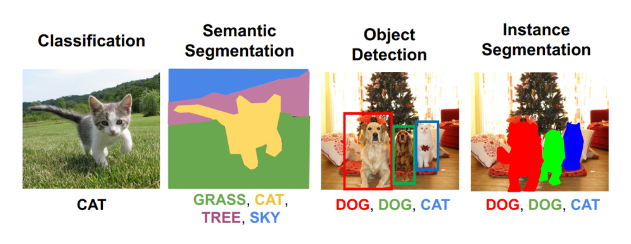

In [3]:
Image('/gdrive/My Drive/Deep learning/CV starting with deep learning/Segmentation.png')

### 2. U-Net 구조를 통한 Semantic Segmetation
#### 2.1 U-Net
  - Encoder-Decoder 모델에 skip connection을 추가한 모델
  - Encoder은 Contracting path로 불리고, Decoder는 Expanding(Expansive) path로 불림.

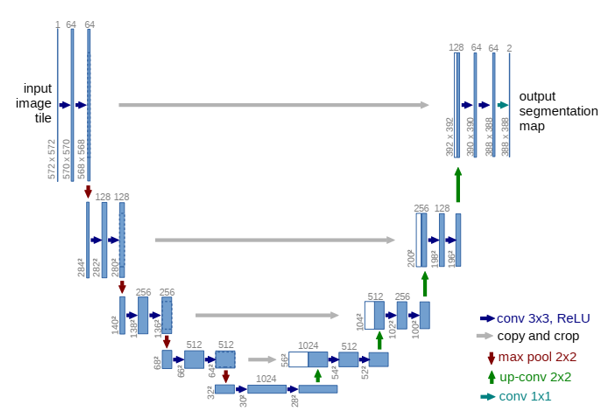

In [2]:
Image('/gdrive/My Drive/Deep learning/CV starting with deep learning/U-Net.png')

- #### 2.2 Contracting path
  - #### convolution 연산
  - #### 이미지가 가지고 있는 context 정보를 추출
  - #### 3x3 kernel을 사용하는 VGG 모델과 유사
  - #### convolution 연산으로 인한 이미지 위치정보 소멸

    - 3*3 conv 2번 (relu 사용, padding 사용 X)
    - 2*2 max pooling
    - Down Sampling 후 convolution channel size가 2배


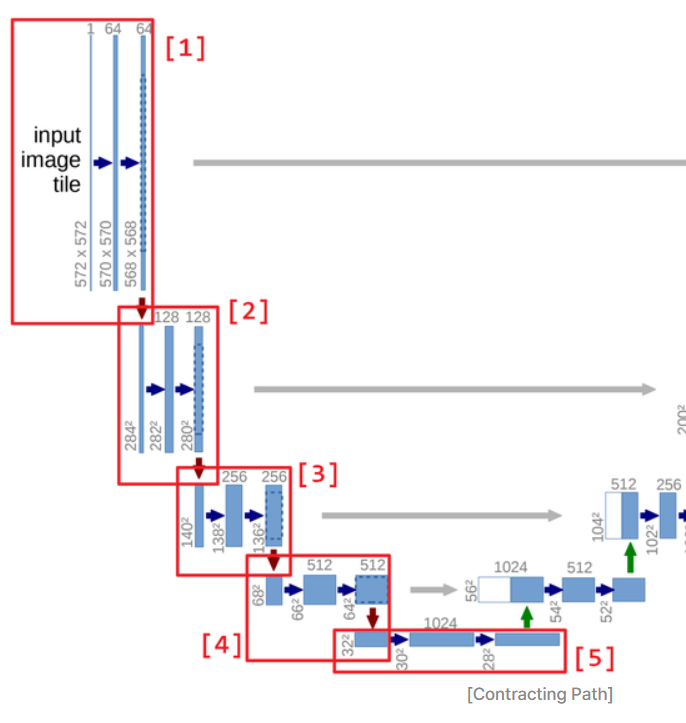

In [9]:
Image('/gdrive/My Drive/Deep learning/CV starting with deep learning/Contracting Path.png', height = 400)

- #### 2.3 Expanding(Expansive) path
  - #### up-convolution 연산
  - #### low resolution의 latent representation을 high resolution으로 변형
  - #### feature map을 cropping 한 결과물이 concatenation
  - #### 이미지의 위치정보 복원
    - 2*2 up-convolution(up-sampling)후 채널 수 2배
    - feature map의 size가 늘어남 (encoding과 동일 하지 않음)
    - Cropped된 feature map과 concatenation
    - 마지막 layer에 1*1 convolution 연산

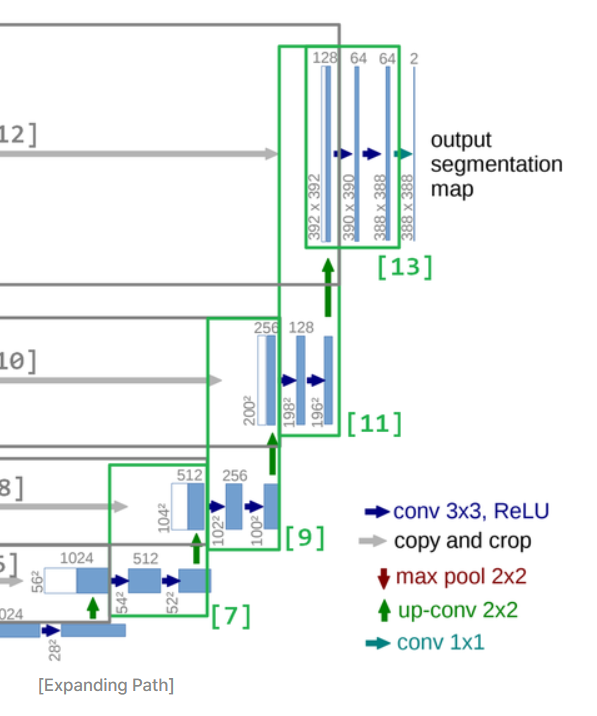

In [10]:
Image('/gdrive/My Drive/Deep learning/CV starting with deep learning/Expanding Path.png', height = 400)

- #### 2.3 Expanding(Expansive) path
  - Decoding 단계에서 저차원의 정보와 고차원의 정보도 함께 이용
  - Encoding 단계에서의 정보 손실을 보충

## 3. U-Net 코드 실습

In [ ]:
!pip install graphviz
!pip install pydot
import tensorflow.keras.layers as layers
import tensorflow as tf

In [ ]:
inputs = layers.Input(shape=(572, 572, 1))

# Contracting path 시작
# [1]
conv0 = layers.Conv2D(64, activation='relu', kernel_size = 3)(inputs)
conv1 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv0)  # Skip connection으로 Expanding path로 이어질 예정
conv2 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv1)


# Q.위 이미지를 보고 [2]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv3 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv2)
conv4 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv3)
conv5 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv4)


# Q.위 이미지를 보고 [3]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv6 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv5)
conv7 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv6)
conv8 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv7)


# Q.위 이미지를 보고 [4]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv9 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv8)
conv10 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv9)
conv11 = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv10)


# [5]
conv12 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv11)
conv13 = layers.Conv2D(1024, activation='relu', kernel_size=3)(conv12)
# Contracting path 끝

# Expanding path 시작
# [6]
trans01 = layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu')(conv13)
crop01 = layers.Cropping2D(cropping=(4, 4))(conv10)
concat01 = layers.concatenate([trans01, crop01], axis=-1)

# [7]
conv14 = layers.Conv2D(512, activation='relu', kernel_size=3)(concat01)
conv15 = layers.Conv2D(512, activation='relu', kernel_size=3)(conv14)
trans02 = layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu')(conv15)

# [8]
crop02 = layers.Cropping2D(cropping=(16, 16))(conv7)
concat02 = layers.concatenate([trans02, crop02], axis=-1)


# Q.위 이미지를 보고 [9]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv16 = layers.Conv2D(256, activation='relu', kernel_size=3)(concat02)
conv17 = layers.Conv2D(256, activation='relu', kernel_size=3)(conv16)
trans03 = layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu')(conv17)


# Q.위 이미지를 보고 [10]번 블럭을 구현해 봅시다. (cropping=(40, 40))
crop03 = layers.Cropping2D(cropping=(40, 40))(conv4)
concat03 = layers.concatenate([trans03, crop03], axis=-1)


# Q.위 이미지를 보고 [11]번 블럭을 구현해 봅시다. (filter 수를 주의하세요!)
conv18 = layers.Conv2D(128, activation='relu', kernel_size=3)(concat03)
conv19 = layers.Conv2D(128, activation='relu', kernel_size=3)(conv18)
trans04 = layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu')(conv19)


# Q.위 이미지를 보고 [12]번 블럭을 구현해 봅시다. (cropping=(88, 88))
crop04 = layers.Cropping2D(cropping=(88, 88))(conv1)
concat04 = layers.concatenate([trans04, crop04], axis=-1)


# [13]
conv20 = layers.Conv2D(64, activation='relu', kernel_size=3)(concat04)
conv21 = layers.Conv2D(64, activation='relu', kernel_size=3)(conv20)
# Expanding path 끝

outputs = layers.Conv2D(2, kernel_size=1)(conv21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [ ]:
model.summary()

In [ ]:
# 구현한 U-Net 모델 구조 시각화
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=80).create(prog='dot', format='svg'))  #dpi를 작게 하면 그래프가 커집니다.

## 4.Transposed Convolution을 코드로 살펴보기

In [ ]:
# 필요한 모듈 불러오기
import numpy as np
import tensorflow as tf

In [ ]:
# input data
X = np.asarray([[1, 2],
			  [3, 4]])

In [ ]:
print(X)
print(X.shape)

In [ ]:
# 모델에 맞게 reshaping
X = X.reshape((1, 2, 2, 1))

In [ ]:
print(X)
print(X.shape)

In [ ]:
# 모델 만들기
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2DTranspose(1, (1, 1), strides=(2, 2), input_shape=(2, 2, 1))) # Conv2DTranspos layer

In [ ]:
# weights를 설정하고 설정한 weights를 모델에 적용합니다.
weights = [np.asarray([[[[1]]]]), np.asarray([1])] # weight = 1, bias = 1

In [ ]:
weights
model.set_weights(weights)
yhat = model.predict(X)
yhat = yhat.reshape((4, 4)) # 결과를 확인하기 편하게 reshaping
print(yhat)